In [1]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
%matplotlib inline
# import netCDF4
# from netCDF4 import num2date
import os
import datetime
import numpy as np
basins = ["california","cascades","northernrockies","southernrockies","whites"]
scenarios = ["historical","rcp45","rcp85"]
variables=["swe","sm"]

/usr/local/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


# TIME SERIES OF AGGREGATE SWE # 

saving figure to '/raid9/gergel/agg_snowpack/plots/agg_swe/swe_gcms.png'


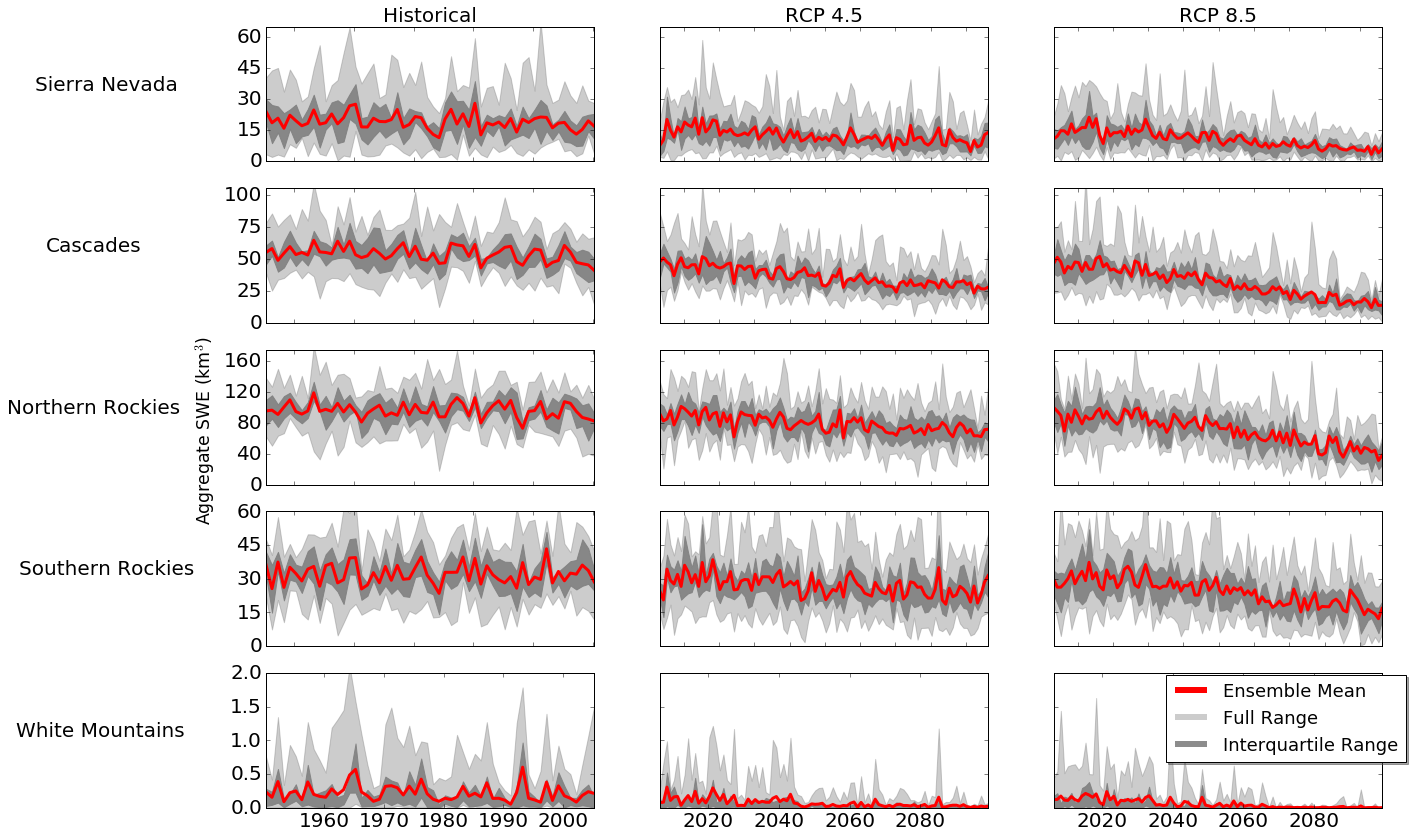

In [2]:
models = ['CNRM-CM5','NorESM1-M','IPSL-CM5A-MR','CanESM2','CCSM4','HadGEM2-CC365','HadGEM2-ES365','MIROC5','bcc-csm1-1-m',
          'CSIRO-Mk3-6-0']
mountain_ranges = ['Sierra Nevada', 'Cascades', 'Northern Rockies', 'Southern Rockies', 'White Mountains']
range_count = 0
import matplotlib.dates 
lt = 20
rt = 14
lw = 3.0
variable = "swe"
num = 0
fig = plt.figure(figsize=(lt,rt))

############# set fontsize ##############
fs = 20 ## fontsize
ls = 15 ## legend size 
lwidth = 6.0 ## linewidth for legend 
#########################################

for basin in basins: 
    for scenario in scenarios: 
        if (scenario == "historical"):
            base = datetime.datetime(1950, 4, 1)
            end_date = datetime.datetime(2006, 4, 1)
        else:
            base = datetime.datetime(2006, 4, 1)
            end_date = datetime.datetime(2100, 4, 1)
        
        ## load ensemble mean data
        direc = '/raid9/gergel/agg_snowpack/%s' %scenario
        file = '%s.npz' %basin
        data = np.load(os.path.join(direc,file))
        swe = data['swe']
        dates = data['dates']
        
        ## load data from each gcm and append to list 
        direc = '/raid9/gergel/agg_snowpack/%s' %scenario
        swelist = list()
        for model in models: 
            filename = '%s_%s.npz' %(model,basin)
            data = np.load(os.path.join(direc,filename))
            swe = data['swe']
            swelist.append(swe)
        swelist = np.asarray(swelist)[:,:,0]
        swemax = np.max(swelist,axis=0)
        swemin = np.min(swelist,axis=0)
        
        if (scenario == "historical"):
            ax = fig.add_subplot(5,3,num+1) 
            ax.yaxis.set_tick_params(labelsize=fs)
                
        else: 
            ax = fig.add_subplot(5,3,num+1,sharey=ax) 
            plt.setp(ax.get_yticklabels(), visible=False)
        
        if num == 0:
            ax.set_title('Historical',fontsize=fs)
        elif num == 1: 
            ax.set_title('RCP 4.5',fontsize=fs)
        elif num == 2:
            ax.set_title('RCP 8.5',fontsize=fs)
        
        ## set mountain range label
        if (scenario == "historical"):
            ax.set_ylabel(mountain_ranges[range_count], size=fs, rotation=0, labelpad=130)
            range_count += 1
        
        if (basin != "whites"):
            plt.setp(ax.get_xticklabels(), visible=False)
        else: 
            if (scenario == "historical"):
                ax.xaxis.set_major_locator(matplotlib.dates.YearLocator(10))
            else:
                ax.xaxis.set_major_locator(matplotlib.dates.YearLocator(20))
            ax.xaxis.set_tick_params(labelsize=fs)
            ax.autoscale_view()
                
        # ax.plot_date(dates,swelist.mean(0),fmt='-',color='r',linewidth=lw,label='Ensemble Mean')
        ax.plot_date(dates,swelist.mean(0),fmt='-',color='r',linewidth=lw)
        ax.fill_between(dates,swemin,swemax,color='grey',alpha=0.4,label='Full Range')
        ax.fill_between(dates,np.percentile(swelist,25,0),np.percentile(swelist,75,0),color='grey',alpha=0.9,label='IQR')
        # ax.set_ylabel('SWE in km^3')
        ########################### set axes
        if (basin == 'whites'):
                plt.ylim((0,2))
                plt.yticks(np.arange(0, 2.5, 0.5))
        elif (basin == "california"):
                plt.ylim((0,65))
                plt.yticks(np.arange(0, 75, 15))
        elif (basin == "cascades"): 
                plt.ylim((0,105))
                plt.yticks(np.arange(0, 125, 25))
        elif (basin == "southernrockies"): 
                plt.ylim((0,60))
                plt.yticks(np.arange(0, 75, 15))
        else:
                plt.ylim((0,175))
                plt.yticks(np.arange(0, 200, 40))
           
        num += 1
        
        ## legend patches
        l1 = mlines.Line2D([], [], color='r', label='Ensemble Mean',linewidth=lwidth)
        l2 = mlines.Line2D([], [], color='grey',alpha=0.4,label='Full Range',linewidth=lwidth)
        l3 = mlines.Line2D([], [], color='grey', alpha=0.9,label='Interquartile Range',linewidth=lwidth)
        # plt.legend(handles=[l1,l2,l3],bbox_to_anchor=(1.1, 1.05),prop={'size':18})
        
        if (basin == "whites" and (scenario == "rcp85")):
            # plt.legend()
            plt.legend(handles=[l1,l2,l3],bbox_to_anchor=(1.1, 1.05),frameon=True,shadow=True,prop={'size':18})

fig.text(0.075, 0.5, 'Aggregate SWE (km$^{3}$)', va='center', rotation='vertical',size = 'xx-large')



## save plot   
direc = '/raid9/gergel/agg_snowpack/plots/agg_swe'
plotname = 'swe_gcms.png' 
savepath = os.path.join(direc, plotname)
print ("saving figure to '%s'" % savepath)
plt.savefig(savepath)

# SWE HEATMAP WITH STATISTICAL SIGNIFICANCE #

In [3]:
def make_df_for_heatmap(modelss,basinss,scenario,fcn,timebeg,timeend):
    import pandas as pd
    from scipy import stats
    diff_means = list()
    pvals = list()
    for model in models: 
        for basin in basins: 
            direc = '/raid9/gergel/agg_snowpack/%s' % "historical"
            file = '%s_%s.npz' %(model,basin)
            data = np.load(os.path.join(direc,file))
            sm_hist = data['swe']
            if fcn == "average":
                sm_hist_mean = np.mean(sm_hist)
            
            direc = '/raid9/gergel/agg_snowpack/%s' %scenario
            file = '%s_%s.npz' %(model,basin)
            data = np.load(os.path.join(direc,file))
            sm = data['swe']
            if fcn == "average":
                sm_mean = np.mean(sm[timebeg:timeend]) 
            
            pvals.append(stats.ttest_ind(sm_hist,sm,equal_var=False)[1])
            diff_means.append(sm_mean - sm_hist_mean)

    diff_means = np.around(np.asarray(diff_means),4)
    pvals = np.asarray(pvals).squeeze()

    d = {'GCMs': modelss, 'Mountain Ranges': basinss, 'means': diff_means}
    d_pvals = {'GCMs': modelss, 'Mountain Ranges': basinss, 'means': pvals}
    df = pd.DataFrame(data=d,index=np.arange(50))
    df_pvals = pd.DataFrame(data=d_pvals,index=np.arange(50))
    df_pivot = df.pivot("Mountain Ranges", "GCMs", "means")
    df_pivot_pvals = df_pvals.pivot("Mountain Ranges", "GCMs", "means")
    
    '''df_pivot = df_pivot.reindex_axis(['cascades', 'california', 'northernrockies','southernrockies','whites','plains',
                                      'nwinterior','coastalnorth','coastalsouth','southwest'], axis=0)'''
    df_pivot = df_pivot.reindex_axis(["Cascades","Sierra Nevada","Northern Rockies","Southern Rockies","White Mountains"], axis=0)
    
    df_pivot_pvals = df_pivot_pvals.reindex_axis(["Cascades","Sierra Nevada","Northern Rockies","Southern Rockies","White Mountains"], 
                                                 axis=0)
    
    '''df_pivot_pvals = df_pivot_pvals.reindex_axis(['cascades', 'california', 'northernrockies','southernrockies',
                                                  'whites','plains','nwinterior','coastalnorth','coastalsouth',
                                                  'southwest'], axis=0)'''
    df_pivot_pvals = df_pivot_pvals.iloc[::-1].values.ravel() ## flips over the dataframe, then makes it one dimension 
                                                              ##so that it can be iterated through the same way as ax.text 
    
    return(df_pivot,diff_means,df_pivot_pvals)

def denote_stat_sig(pvals,pivot_table_values,plot_obj):
    count = 0
    for text in plot_obj.texts:
        text.set_size(8)
        if pvals[count] < 0.05: 
            text.set_color('black')
            text.set_weight('bold')
            text.set_style('italic')
        count += 1 
    return(plot_obj)

# SWE HEATMAP WITH STATISTICAL SIGNIFICANCE: NORMALIZED # 

In [4]:
def make_df_for_heatmap(modelss,basinss,scenario,fcn,timechunk):
    import pandas as pd
    from scipy import stats
    diff_means = list()
    pvals = list()
    for model in models: 
        for basin in basins: 
            direc = '/raid9/gergel/agg_snowpack/swe_t_p_reg/proc_data'
            file = '%s_%s_%s.npz' %(model,basin,"historical")
            data = np.load(os.path.join(direc,file))
            sm_hist = data['swe']
            if fcn == "average":
                sm_hist_mean = np.mean(sm_hist)
            
            direc = '/raid9/gergel/agg_snowpack/swe_t_p_reg/proc_data'
            file = '%s_%s_%s.npz' %(model,basin,scenario)
            data = np.load(os.path.join(direc,file))
            if (timechunk == "2020s"):
                sm = data['swe_2010_2039']
            elif (timechunk == "2050s"):
                sm = data['swe_2040_2069']
            else:
                sm = data['swe_2070_2099']
            if fcn == "average":
                sm_mean = np.mean(sm) 
            
            pvals.append(stats.ttest_ind(sm_hist,sm,equal_var=False)[1])
            # diff_means.append(sm_mean - sm_hist_mean)
            diff_means.append(sm_hist_mean)

    diff_means = np.around(np.asarray(diff_means),4)
    pvals = np.around(np.asarray(pvals).squeeze(),0)

    d = {'GCMs': modelss, 'Mountain Ranges': basinss, 'means': diff_means}
    d_pvals = {'GCMs': modelss, 'Mountain Ranges': basinss, 'means': pvals}
    df = pd.DataFrame(data=d,index=np.arange(50))
    df_pvals = pd.DataFrame(data=d_pvals,index=np.arange(50))
    df_pivot = df.pivot("Mountain Ranges", "GCMs", "means")
    df_pivot_pvals = df_pvals.pivot("Mountain Ranges", "GCMs", "means")
    
    df_pivot = df_pivot.reindex_axis(["Cascades","Sierra Nevada","Northern Rockies","Southern Rockies","White Mountains"], axis=0)
    
    df_pivot_pvals_f = df_pivot_pvals.reindex_axis(["Cascades","Sierra Nevada","Northern Rockies","Southern Rockies","White Mountains"], 
                                                 axis=0)
    
    df_pivot_pvals = df_pivot_pvals_f.iloc[::-1].values.ravel() ## flips over the dataframe, then makes it one dimension 
                                                              ##so that it can be iterated through the same way as ax.text 
    
    return(df_pivot,diff_means,df_pivot_pvals_f,df_pivot_pvals)

def denote_stat_sig(pvals,pivot_table_values,plot_obj):
    count = 0
    for text in plot_obj.texts:
        text.set_size(9)
        if pvals[count] < 0.05: 
            text.set_color('blue')
            text.set_weight('bold')
            text.set_style('italic')
        count += 1 
    return(plot_obj)

# CREATE SWE HEATMAP #

In [5]:
lt = 35
rt = 18
# fig = plt.figure(figsize=(lt,rt))

import seaborn as sns
import pandas as pd
basins = ["cascades","california","northernrockies","southernrockies","whites"]
basins_reformatted = ["Cascades","Sierra Nevada","Northern Rockies","Southern Rockies","White Mountains"]

models = ['CNRM-CM5','NorESM1-M','IPSL-CM5A-MR','CanESM2','CCSM4','HadGEM2-CC365','HadGEM2-ES365','MIROC5','bcc-csm1-1-m',
          'CSIRO-Mk3-6-0']
basins_10 = np.asarray(basins_reformatted*10)
models_10 = np.asarray(models*5).reshape(5,10).T.ravel()

scens = ["rcp45","rcp45","rcp45","rcp85","rcp85","rcp85"]
climate_periods = ["2020s","2050s","2080s","2020s","2050s","2080s"]

vm = -400
ann = False
f = ".1f"
fs = 25

## set axes and label sizes. There is a Github pull request that describes how to do this: 
#############################  https://github.com/mwaskom/seaborn/issues/181
rc={'font.size': fs, 'axes.labelsize': fs,'axes.titlesize': fs, 'xtick.labelsize': fs, 'ytick.labelsize': fs}
sns.set_context(rc=rc)

fig, axn = plt.subplots(2, 3, sharex=True, sharey=True,figsize=(lt,rt))
cbar_ax = fig.add_axes([.91, .3, .03, .4])

scens = ["rcp45","rcp45","rcp45","rcp85","rcp85","rcp85"]
climate_periods = ["2020s","2050s","2080s","2020s","2050s","2080s"]

figcount = 0
for i, ax in enumerate(axn.flat):
    df_pivot,diff_means,pvals_df,pvals = make_df_for_heatmap(models_10,basins_10,scens[figcount],
                                                             "average",climate_periods[figcount])
    sns.heatmap(df_pivot, annot=ann, ax=ax, cbar=i == 0, cbar_ax=None if i else cbar_ax, fmt=f,linewidths=.5,
                cmap='Reds_r',cbar_kws={"extend": 'min'},
                vmin=vm,vmax=0)
    maskk = pvals_df < 0.05
   sns.heatmap(df_pivot, mask=maskk, ax=ax, cbar=False,cmap='gray',
                annot=True,annot_kws={"size": "10","alpha":"0.0","text":"%.1d"})
    locs, labels = plt.yticks()
    if scens[figcount] == "rcp45":
        ax.set_title(climate_periods[figcount],size=fs)
        plt.setp(ax.get_xticklabels(),visible=False)
        ax.get_xaxis().set_visible(False)
    else: 
        plt.setp(labels, rotation=360)
    if climate_periods[figcount] != "2020s":
        plt.setp(ax.get_yticklabels(),visible=False)
        ax.get_yaxis().set_visible(False) 
    else: 
        plt.setp(ax.yaxis.get_label(),visible=False) ## set y-axis labels to invisible 
    if climate_periods[figcount] != "2050s":
        plt.setp(ax.xaxis.get_label(),visible=False) ## set y-axis labels to invisible 
    figcount += 1 

# cbar_ax.set_label('[mm]',rotation='horizontal')
cbar_ax.text(1.8,0.5,'[mm]',rotation='horizontal',size=fs)

fig.text(0.075, 0.5, 'rcp85', va='center', rotation='horizontal',size = fs)
fig.text(0.075, 0.93, 'rcp45', va='center', rotation='horizontal',size = fs)
fig.text(0.0, 0.5, 'Mountain Ranges', va='center', rotation='vertical',size = fs)

## save plot
direc = '/raid9/gergel/agg_snowpack/plots/summer_sm'
plotname = 'heatmap_swe_gcms_30yr_changeinmeans_stat_sig_normalized' 
savepath = os.path.join(direc, plotname)
print ("saving figure to '%s'" % savepath)
plt.savefig(savepath,dpi=150)

IndentationError: unindent does not match any outer indentation level (<ipython-input-5-ac25f298ec49>, line 42)

# CREATE TABLE WITH SWE CHANGE RANGE #

In [ ]:
df_pivot,diff_means,pvals_df,pvals = make_df_for_heatmap(models_10,basins_10,"rcp85",
                                                             "average","2080s")
df_pivot

In [ ]:
print("Sierra Nevada: average: %.2f, min: %.2f, max: %.2f" % (df_pivot.values[1,:].mean(), 
                                                              np.abs(df_pivot.values[1,:]).min(), 
                                                               np.abs(df_pivot.values[1,:]).max()))
print("Cascades: average: %.2f, min: %.2f, max: %.2f" % (df_pivot.values[0,:].mean(), 
                                                         np.abs(df_pivot.values[0,:]).min(), 
                                                            np.abs(df_pivot.values[0,:]).max()))
print("NR: average: %.2f, min: %.2f, max: %.2f" % (df_pivot.values[2,:].mean(), 
                                                              np.abs(df_pivot.values[2,:]).min(), 
                                                               np.abs(df_pivot.values[2,:]).max()))
print("SR: average: %.2f, min: %.2f, max: %.2f" % (df_pivot.values[3,:].mean(), 
                                                              np.abs(df_pivot.values[3,:]).min(), 
                                                               np.abs(df_pivot.values[3,:]).max()))
print("Whites: average: %.2f, min: %.2f, max: %.2f" % (df_pivot.values[4,:].mean(), 
                                                              np.abs(df_pivot.values[4,:]).min(), 
                                                               np.abs(df_pivot.values[4,:]).max()))